# Machine-Learning

### Recommendations: Linear Reg, DTRegression, NeuralNetwork, SVM, LogisticReg

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # Random Split
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.preprocessing import StandardScaler

from sklearn import set_config
set_config(transform_output="pandas") # Keeps feature names after pipeline

In [2]:
def calculate_score(y_true, y_pred):
    print(f"R2 Score {r2_score(y_true, y_pred)}")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_true, y_pred))}")

def plot(y_true, y_pred):
    f, axes = plt.subplots(1,1, figsize=(24,12))

    axes.scatter(y_true,y_pred,color = "green")
    axes.plot(y_true, y_true, 'b-', linewidth = 1)

In [3]:
df = pd.read_csv('data/clean_listing.csv')
df.head()

,Unnamed: 0,host_response_rate,latitude,longitude,accommodates,bedrooms,beds,price,availability_365,number_of_reviews,...,Bed linens,Iron,Clothing storage,TV,host_since_years,distance_from_MRT,distance_from_Bus,distance_from_Mall,distance_from_School,distance_from_Food
0,0,0.9,1.34754,103.95958,1,1.0,1.0,81.0,242,24,...,False,False,False,True,12,0.842953,0.180102,7.976199,3.515767,0.785094
1,1,0.9,1.34531,103.96100,2,1.0,2.0,81.0,305,47,...,False,False,False,True,12,0.880282,0.205346,7.952045,3.786036,0.502588
2,2,1.0,1.29015,103.80814,1,1.0,1.0,52.0,273,22,...,False,False,False,True,12,0.549557,0.117975,4.230675,1.095807,0.169376
3,3,1.0,1.28836,103.81144,1,1.0,1.0,49.0,281,14,...,False,False,False,True,12,0.609339,0.040906,3.862544,0.685090,0.208523
4,4,0.9,1.34490,103.95979,4,3.0,5.0,175.0,242,12,...,False,True,False,True,12,0.738518,0.210803,7.816646,3.809634,0.506811


In [4]:
print(f"The standard deviation of price of listing is ${df['price'].std():.2f}.")

The standard deviation of price of listing is $132.36.


In [5]:
# Split data
Y = df['price']
X = df.drop(['price', 'Unnamed: 0', 'latitude', 'longitude'], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=45)

In [7]:
X.head()

,host_response_rate,accommodates,bedrooms,beds,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,...,Bed linens,Iron,Clothing storage,TV,host_since_years,distance_from_MRT,distance_from_Bus,distance_from_Mall,distance_from_School,distance_from_Food
0,0.9,1,1.0,1.0,242,24,4.16,4.22,4.09,4.43,...,False,False,False,True,12,0.842953,0.180102,7.976199,3.515767,0.785094
1,0.9,2,1.0,2.0,305,47,4.41,4.39,4.52,4.63,...,False,False,False,True,12,0.880282,0.205346,7.952045,3.786036,0.502588
2,1.0,1,1.0,1.0,273,22,4.40,4.16,4.26,4.47,...,False,False,False,True,12,0.549557,0.117975,4.230675,1.095807,0.169376
3,1.0,1,1.0,1.0,281,14,4.50,4.69,4.23,4.62,...,False,False,False,True,12,0.609339,0.040906,3.862544,0.685090,0.208523
4,0.9,4,3.0,5.0,242,12,4.83,4.67,4.75,4.58,...,False,True,False,True,12,0.738518,0.210803,7.816646,3.809634,0.506811


### Model 1: Linear Regression

Train
 Score: 0.5520436293748121
R2 Score 0.5520436293748121
RMSE : 89.03003231619196
Test
 Score: 0.5523829452297175
R2 Score 0.5523829452297175
RMSE : 86.69243760598245


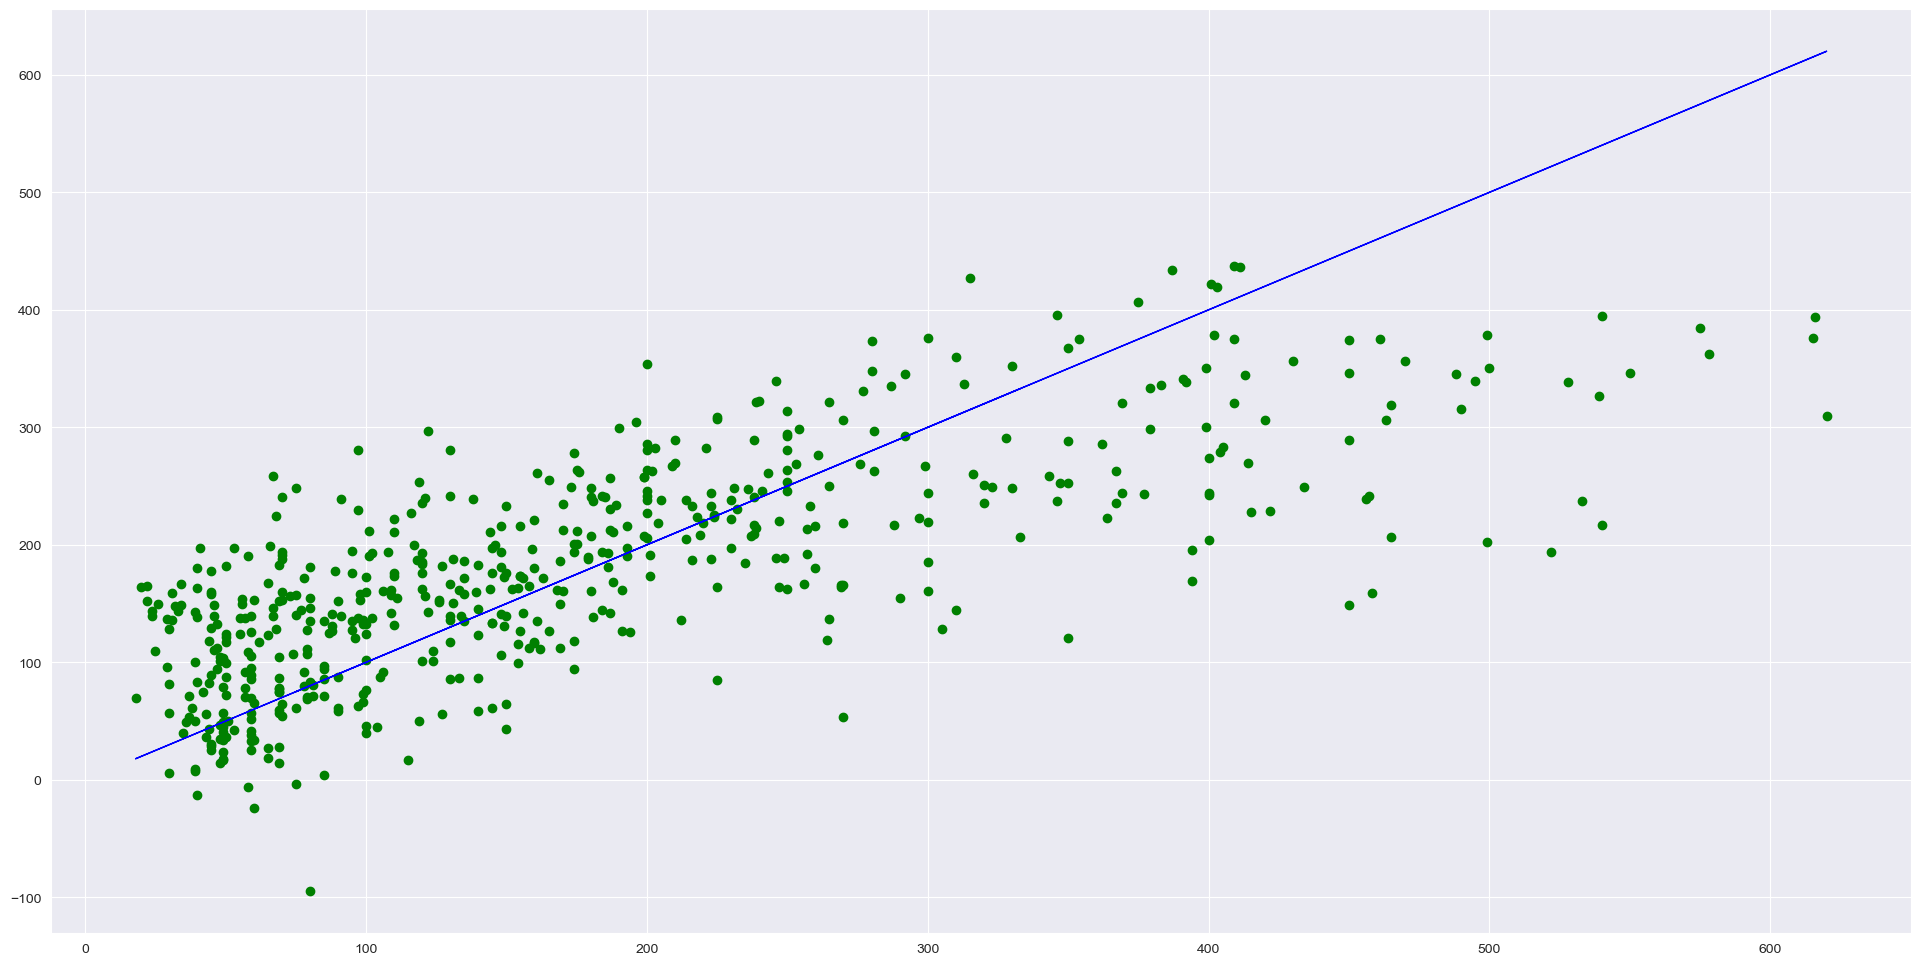

In [8]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

reg.fit(X_train, y_train)

y_train_pred = reg.predict(X_train)
y_pred = reg.predict(X_test)

print(f"Train\n Score: {reg.score(X_train, y_train)}")
calculate_score(y_train, y_train_pred)

print(f"Test\n Score: {reg.score(X_test, y_test)}")
calculate_score(y_test, y_pred)

plot(y_test, y_pred)

### Model 2: Gradient Boost Regressor

Train
Score: 0.9421828079740432
R2 Score 0.9421828079740432
RMSE : 31.98506003591362
Test
Score: 0.7548598210728407
R2 Score 0.7548598210728407
RMSE : 64.15568572361914


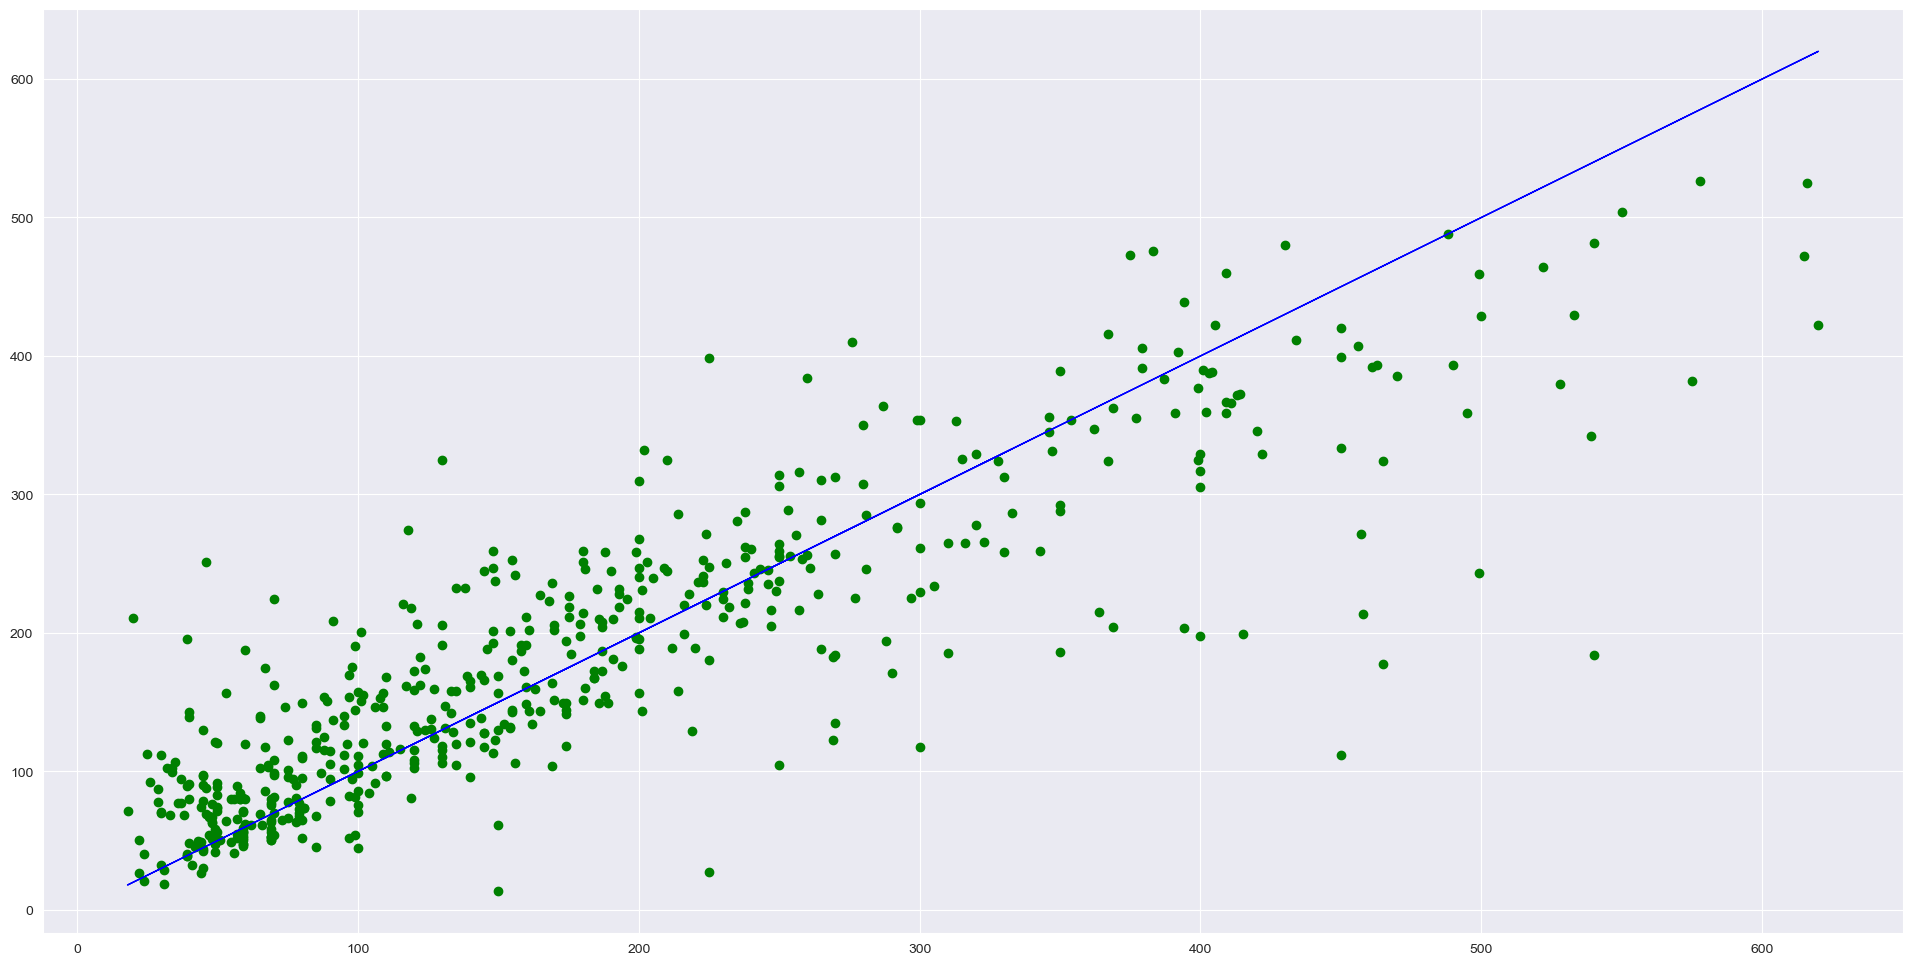

In [9]:
from sklearn.ensemble import HistGradientBoostingRegressor

reg = HistGradientBoostingRegressor()

reg.fit(X_train, y_train)

y_train_pred = reg.predict(X_train)
y_pred = reg.predict(X_test)

print(f"Train\nScore: {reg.score(X_train, y_train)}")
calculate_score(y_train, y_train_pred)

print(f"Test\nScore: {reg.score(X_test, y_test)}")
calculate_score(y_test, y_pred)

plot(y_test, y_pred)

### Model 3: XGBoost Regression

We can use gradient boosting - a type of ensemble machine learning algorithms. Ensemble is a collection of decision trees. Every iteration, a decision tree is added to model to minimise the error. Models are fit using any arbitrary differentiable loss function and gradient descent optimization algorithm, and the goal is to minimise loss gradient. We will use XGBoost API to do the model fitting.

Train
Score:1.0
R2 Score 0.9922401401529766
RMSE : 11.717787316093212
Test
Score:0.7498095082568357
R2 Score 0.7498095082568357
RMSE : 64.8131758217877


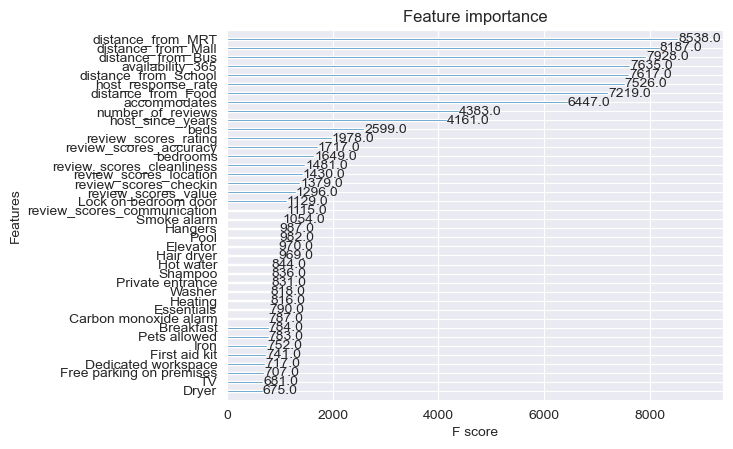

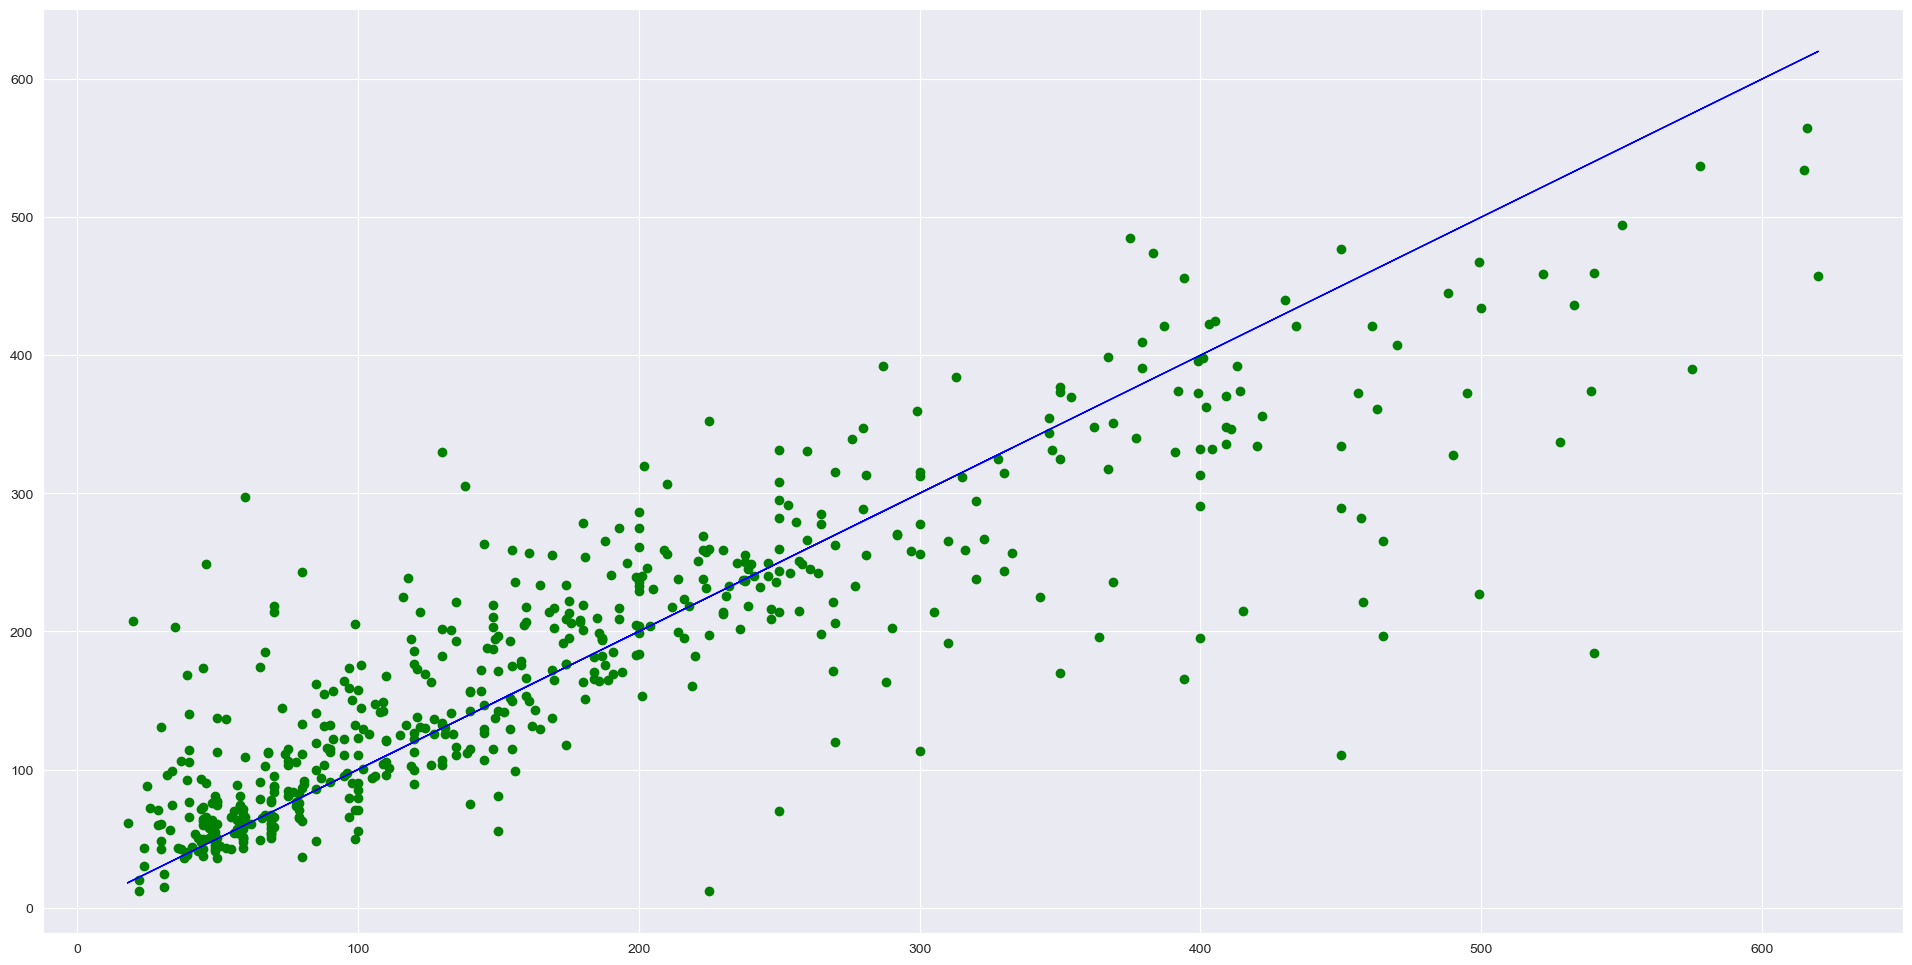

In [10]:
import xgboost as xgb
import graphviz

model = xgb.XGBRegressor(tree_method='hist', objective='reg:squarederror', n_estimators = 2500,
                         learning_rate=0.01)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

print(f"Train\nScore:{model.score(X_train, y_train_pred)}")
calculate_score(y_train, y_train_pred)

print(f"Test\nScore:{model.score(X_test, y_test)}")
calculate_score(y_test, y_pred)

xgb.plot_importance(model.get_booster(), max_num_features=40)

plot(y_test, y_pred)

### Model 4: Neural Networks

In [11]:
X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, Y, test_size=0.33, random_state=101)

s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float64))
X_val_and_test = s_scaler.transform(X_val_and_test.astype(np.float64))

X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=0.5)

In [12]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(256, activation='linear', input_shape=(len(X_val.columns), )))
model.add(Dense(128, activation='linear'))
model.add(Dense(64, activation='linear'))
model.add(Dense(32, activation='linear'))
model.add(Dense(16, activation='linear'))
model.add(Dense(8, activation='linear'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

Input (n layers) -> Hidden Layer 1 (32 layers) -> Hidden Layer 2 (32 layers) -> Output (1 layer): Price

In [13]:
model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,epochs=600)
model.summary()

Epoch 1/600
15/15 [==============================] - 1s 19ms/step - loss: 48335.3633 - val_loss: 42722.3008
Epoch 2/600
15/15 [==============================] - 0s 4ms/step - loss: 41289.5977 - val_loss: 35660.3984
Epoch 3/600
15/15 [==============================] - 0s 4ms/step - loss: 35483.1172 - val_loss: 29883.7246
Epoch 4/600
15/15 [==============================] - 0s 4ms/step - loss: 26357.9668 - val_loss: 17746.4258
Epoch 5/600
15/15 [==============================] - 0s 4ms/step - loss: 12674.9082 - val_loss: 8970.1816
Epoch 6/600
15/15 [==============================] - 0s 3ms/step - loss: 9507.9883 - val_loss: 8077.4673
Epoch 7/600
15/15 [==============================] - 0s 4ms/step - loss: 8880.9238 - val_loss: 8233.0996
Epoch 8/600
15/15 [==============================] - 0s 3ms/step - loss: 8841.9551 - val_loss: 7972.1211
Epoch 9/600
15/15 [==============================] - 0s 4ms/step - loss: 8586.2041 - val_loss: 8495.0537
Epoch 10/600
15/15 [=========================

We can conclude that:... .

<Axes: >

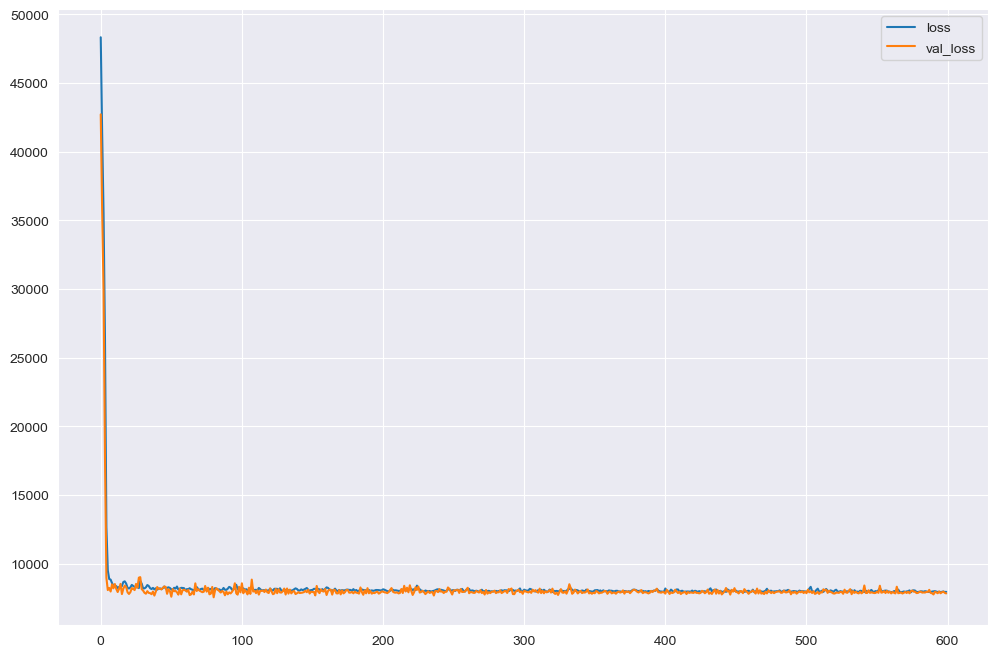

In [14]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize=(12,8))


15/15 [==============================] - 0s 1ms/step
RMSE: 88.50494840571876
R^2 Score: 0.5684789434839366


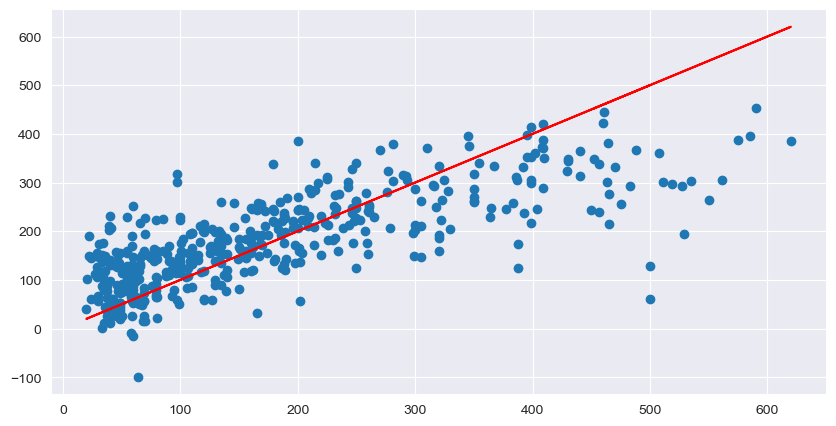

In [16]:
y_pred = model.predict(X_test)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2 Score:',explained_variance_score(y_test,y_pred))
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
# Perfect predictions
plt.plot(y_test,y_test,'r')